In [28]:
import pandas as pd
import scipy.stats as ss
import statsmodels.api as sm
import math as mt
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Statistical Experiments Significance Testing

## Random Permutation
data: https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv

In [7]:
def permutation_function(dataframe, data_col, grouping_col, iterations, statistic_function):
    output = {}
    
    groups = dataframe[grouping_col].value_counts().index
    values = dataframe[grouping_col].value_counts()
    
    for x in range(iterations):
        for i in groups:
            sample_amount = dataframe[grouping_col].value_counts()[i]
            sample_data = dataframe[data_col].sample(sample_amount, replace=False).to_list()
            sample_metric = statistic_function(sample_data)
            try:
                output[i].append(sample_metric)
            except (KeyError, AttributeError):
                output[i] = [sample_metric]
    
    final_output = pd.DataFrame(output)
    return final_output

In [4]:
abTestImport = pd.read_csv("ab_data.csv")
abTestImport

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [12]:
i = abTestImport[
    (
        (abTestImport["group"] == "treatment")
        == (abTestImport["landing_page"] == "new_page")
    )
    == False
].index
df2 = abTestImport.drop(i)
df2

,user_id,timestamp,group,landing_page,converted,group_landing_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,controlold_page
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,controlold_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,treatmentnew_page
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,treatmentnew_page
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,controlold_page
...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,controlold_page
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,controlold_page
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,controlold_page
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,controlold_page


In [14]:
permutationData = permutation_function(df2, "converted", "group", 500, np.mean)
permutationData

,treatment,control
0,0.119062,0.119836
1,0.120480,0.119491
2,0.119083,0.118879
3,0.120108,0.119010
4,0.118959,0.119581
...,...,...
495,0.120149,0.119140
496,0.119564,0.119189
497,0.118780,0.120669
498,0.120466,0.119739


<AxesSubplot:>

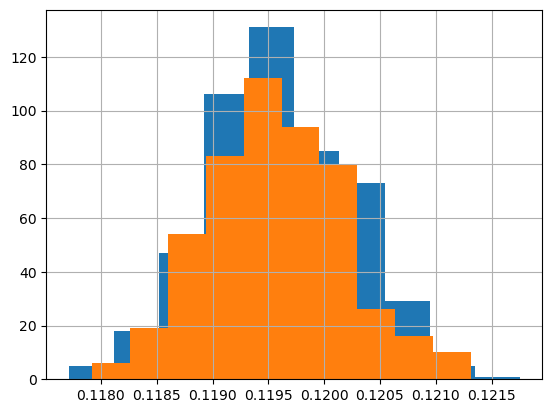

In [15]:
permutationData["treatment"].hist()
permutationData["control"].hist()

## Statistical Significance and p-value

### t-Test

In [17]:
# t-Test

res = ss.ttest_ind(df2[df2['group'] == "control"]["converted"],
                     df2[df2['group'] == "treatment"]["converted"],
                     equal_var=False)
print(f'p-value for single sided test: {res.pvalue/2:.4f}')

p-value for single sided test: 0.0948


### ANOVA (Analysis of Variance) Test

In [18]:
four_sessions = pd.read_csv("four_sessions.csv")
four_sessions

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172
5,Page 2,191
6,Page 3,193
7,Page 4,166
8,Page 1,177
9,Page 2,182


In [22]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

def perm_test(df): 
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
Pr(Prob) 0.079


In [30]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
print(aov_table)
res = ss.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time,
                 four_sessions[four_sessions.Page == 'Page 2'].Time,
                 four_sessions[four_sessions.Page == 'Page 3'].Time,
                 four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic/2:.4f}')
print(f'p-value: {res.pvalue/2:.4f}')

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN
F-Statistic: 1.3699
p-value: 0.0388


## Chi-Square Test

In [33]:
clickImport = pd.read_csv("click_rates.csv")
clicks = clickImport.pivot(index='Click', columns='Headline', values='Rate')

In [36]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4700


In [35]:
chisq, pvalue, df, expected = ss.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


## Power and Sample Size

In [40]:
# estimate sample size via power analysis
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect = 0.8
alpha = 0.05
power = 0.8
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 25.525


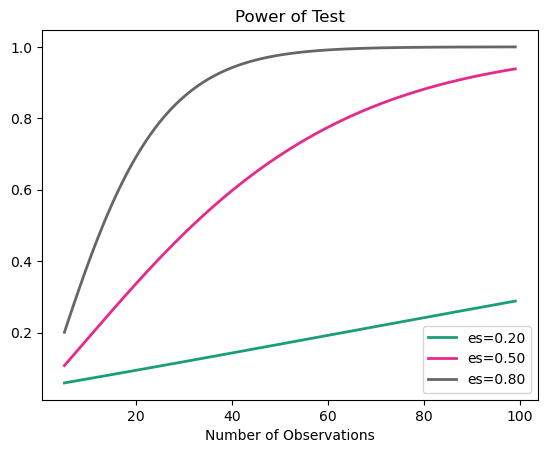

In [38]:
# calculate power curves for varying sample and effect size
from numpy import array
from matplotlib import pyplot
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect_sizes = array([0.2, 0.5, 0.8])
sample_sizes = array(range(5, 100))
# calculate power curves from multiple power analyses
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
pyplot.show()

source: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

In [42]:
def ruleOfThumb(currentEffect, effectSize):
    return 16*(currentEffect*(1-currentEffect))/pow(effectSize,2)

source: https://www.kaggle.com/code/myzziah/e-commerce-a-b-testing-full-experiment/notebook